In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
print("="*70)
print("STEP 1: Load and prepare data")
print("="*70)

STEP 1: Load and prepare data


In [22]:
df = pd.read_csv("transform_readings.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [23]:
# Handle missing & anomalies
df = df.interpolate(method='linear')
df = df[(df['gravity'] > 0.9) & (df['gravity'] < 1.5)]
df = df[(df['brix'] > -5) & (df['brix'] < 30)]
df = df[(df['temperature'] > 10) & (df['temperature'] < 50)]
df = df.sort_values('timestamp')

In [41]:
# Keep the main features
features = ['gravity', 'brix', 'temperature']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(scaled, columns=features)

In [5]:
print("="*70)
print("STEP 2: Scaling")
print("="*70)

STEP 2: Scaling


In [26]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [27]:
print("="*70)
print("STEP 3: Create sequences for LSTM")
print("="*70)

STEP 3: Create sequences for LSTM


In [28]:
def create_sequences(data, seq_len=15):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i+seq_len].values
        target = data.iloc[i+seq_len].values  # predict next reading
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

SEQ_LEN = 15
X, y = create_sequences(df_scaled, SEQ_LEN)

# Split train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train_reg, y_test_reg = y[:split], y[split:]

In [29]:
print("="*70)
print("STEP 4: CREATE CLASSIFICATION TARGET (based on actual next-step brix)")
print("="*70)

STEP 4: CREATE CLASSIFICATION TARGET (based on actual next-step brix)


In [30]:
# 1 = fermented, 0 = not fermented
y_train_class = np.where(y_train_reg[:, 1] <= 0.4, 1, 0)
y_test_class = np.where(y_test_reg[:, 1] <= 0.4, 1, 0)

In [32]:
print("="*70)
print("STEP 5: BUILD MULTI-OUTPUT LSTM MODEL")
print("="*70)

STEP 5: BUILD MULTI-OUTPUT LSTM MODEL


In [33]:
inputs = Input(shape=(SEQ_LEN, len(features)))
x = LSTM(64, return_sequences=False)(inputs)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Forecasting head (3 outputs)
forecast_output = Dense(3, activation='linear', name='forecast_output')(x)

# Classification head (1 output)
class_output = Dense(1, activation='sigmoid', name='class_output')(x)

# Define multi-output model
model = Model(inputs=inputs, outputs=[forecast_output, class_output])

# Compile with weighted losses
model.compile(
    optimizer='adam',
    loss={
        'forecast_output': 'mse',
        'class_output': 'binary_crossentropy'
    },
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 15, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     17,408 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forecast_output     │ (None, 3)         │         99 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 1)         │         33 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,620 (76.64 KB)

 Trainable params: 19,620 (76.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
print("="*70)
print("STEP 5: Train the model")
print("="*70)

STEP 5: Train the model


In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    {'forecast_output': y_train_reg, 'class_output': y_train_class},
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - class_output_accuracy: 0.5918 - class_output_loss: 0.6898 - forecast_output_loss: 0.1952 - loss: 0.8851 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.6412 - val_forecast_output_loss: 0.0301 - val_loss: 0.6713
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - class_output_accuracy: 0.8016 - class_output_loss: 0.6321 - forecast_output_loss: 0.0280 - loss: 0.6603 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.5300 - val_forecast_output_loss: 0.0113 - val_loss: 0.5416
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - class_output_accuracy: 0.8986 - class_output_loss: 0.4511 - forecast_output_loss: 0.0335 - loss: 0.4843 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.2352 - val_forecast_output_loss: 0.0598 - val_loss: 0.2950
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - class_output_accuracy: 0.9044 - class_output_loss: 0.2632 - forecast_output_loss: 0.0458 - loss: 0.3091 - val

In [35]:
print("="*70)
print("STEP 6: Evaluate Model")
print("="*70)

STEP 6: Evaluate Model


In [36]:
loss, forecast_loss, class_loss, class_acc = model.evaluate(
    X_test, {'forecast_output': y_test_reg, 'class_output': y_test_class}, verbose=0
)
print(f"\n✅ Model Classification Accuracy: {class_acc*100:.2f}%")
print(f"Forecast Loss (MSE): {forecast_loss:.6f}")


✅ Model Classification Accuracy: 100.00%
Forecast Loss (MSE): 0.012643


In [37]:
print("="*70)
print("STEP 7: PREDICT & CHECK PERFORMANCE")
print("="*70)

STEP 7: PREDICT & CHECK PERFORMANCE


In [38]:
forecast_pred, class_pred = model.predict(X_test)

# Inverse scale the forecast
forecast_pred_inv = scaler.inverse_transform(forecast_pred)
y_test_reg_inv = scaler.inverse_transform(y_test_reg)

# Classification evaluation
y_pred_labels = (class_pred > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       187

    accuracy                           1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187



In [18]:
print("="*70)
print("# STEP 8: Visualization")
print("="*70)

# STEP 8: Visualization


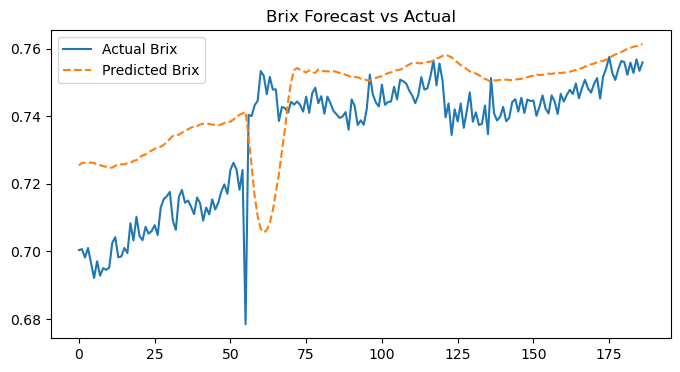

In [39]:
plt.figure(figsize=(8,4))
plt.plot(y_test_reg_inv[:, 1], label='Actual Brix')
plt.plot(forecast_pred_inv[:, 1], label='Predicted Brix', linestyle='--')
plt.legend()
plt.title("Brix Forecast vs Actual")
plt.show()

In [42]:
print("="*70)
print("# STEP 9: Save the model")
print("="*70)

# STEP 9: Save the model


In [43]:
model.save("fermentation_multitask_lstm.h5")
print("\n✅ Saved model as fermentation_multitask_lstm.h5")


✅ Saved model as fermentation_multitask_lstm.h5
